In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
%matplotlib inline
import pickle
import pandas as pd
from tasks import wsd
from pathlib import Path
from tasks import wsd
from utils import nlp_tools
from tqdm.auto import tqdm
import numpy as np
import json
from sklearn.metrics import classification_report
from flair.embeddings import TransformerWordEmbeddings
from utils.dataset_download import harvest_data_from_extended_senses
from utils.classificaton_utils import binarize, vectorize_target_expressions,cosine_similiarity

# Preparation

This part of the notebook prepares data including downloading and vectorizing target words in quotations.

In [6]:
# import API credentials
with open('oed_experiments/oed_credentials.json') as f:
    auth = json.load(f)

Harvest data given a lemma and part-of-speech.

In [4]:
# only run this once after downloading
# otherwise you remove the vectorized keywords
tqdm.pandas()
lemma,pos = 'machine', "NN"
quotations = harvest_data_from_extended_senses(auth,f"{lemma}_{pos}")

[LOG] Loading data from pickled file
[LOG] Shape of senses dataframe = (5136, 17)
[LOG] Shape of quotations dataframe = (30811, 9)
[LOG] Saving pickle file to "./data/sfrel_quotations_machine_NN.pickle"
[LOG] Shape of final dataframe = (30752, 12)


# Vectorize data

Vectorize the target words of quotations. The `embedding_methods` specifies which models to load and the number of layers we use for creating a contextualized vector representation.

In [5]:

quotations_path = "./data/sfrel_quotations_machine_NN.pickle"
embedding_methods = {'bert_base': {"path":'bert-base-uncased',
                                   'layers':'-1,-2,-3,-4',
                                   'pooling_operation':'mean'},
                     'blert': {"path":'/deezy_datadrive/kaspar-playground/bert_model/FT_bert_base_uncased_all_books_v002',
                                    'layers':'-1,-2,-3,-4',
                                    'pooling_operation':'mean'},
                    #'bert_1850':{"path":"/datadrive/khosseini/LM_with_bert_MOVED_to_another_VM_REMOVE_FROM_NOVEMBER/models/bert/FT_bert_base_uncased_before_1850_v001", 
                    #               'layers':'-1,-2,-3,-4',
                    #               'pooling_operation':'mean'},
                    # 'bert_1900': {"path":"/datadrive/khosseini/LM_with_bert_MOVED_to_another_VM_REMOVE_FROM_NOVEMBER/models/bert/FT_bert_base_uncased_after_1890_before_1900_v002",
                    #              'layers':'-1,-2,-3,-4',
                    #                'pooling_operation':'mean'},
                    # 'bert_1875': {"path":"/datadrive/khosseini/LM_with_bert_MOVED_to_another_VM_REMOVE_FROM_NOVEMBER/models/bert/FT_bert_base_uncased_after_1850_before_1875_v002",
                    #                'layers':'-1,-2,-3,-4',
                    #               'pooling_operation':'mean'},
                    #  'bert_1890': {"path":"/datadrive/khosseini/LM_with_bert_MOVED_to_another_VM_REMOVE_FROM_NOVEMBER/models/bert/FT_bert_base_uncased_after_1875_before_1890_v002",
                    #                'layers':'-1,-2,-3,-4',
                    #                'pooling_operation':'mean'}
                                    }
quotations = vectorize_target_expressions(quotations_path,embedding_methods)

[WARNING] Could not properly match shake up  with  shake up			  Return None.
[WARNING] 'vectors' variable is empty. Return None.
[WARNING] 'vectors' variable is empty. Return None.
[WARNING] 'vectors' variable is empty. Return None.
[WARNING] 'vectors' variable is empty. Return None.
[WARNING] 'vectors' variable is empty. Return None.
[WARNING] 'vectors' variable is empty. Return None.
[WARNING] Could not properly match lay  with  layman  Return None.



[WARNING] Could not properly match shake up  with  shake up			  Return None.
[WARNING] 'vectors' variable is empty. Return None.
[WARNING] 'vectors' variable is empty. Return None.
[WARNING] 'vectors' variable is empty. Return None.
[WARNING] 'vectors' variable is empty. Return None.
[WARNING] 'vectors' variable is empty. Return None.
[WARNING] 'vectors' variable is empty. Return None.
[WARNING] Could not properly match lay  with  layman  Return None.



# Disambiguation

This part of the notebook is concerned with disambiguating a specific sense. In the cell below we define the sense and the expansion (`relations`).

In [7]:
tqdm.pandas()
lemma,pos = 'machine', "NN"
senses = {'machine_nn01-38474140'} # machine_nn01-38475772 machine_nn01-38475923 machine_nn01-38475835 machine_nn01-38474140
relations = ['seed','synonym'] # ,'descendant','sibling'
eval_mode = "lemma_etal" # lemma or lemma_etal
    

`binarize` splits the selected quotations in train, validation and test set.

In [8]:
df_train, df_val, df_test = binarize(lemma,
                        pos,
                        senses, 
                        relations,
                        strict_filter=True,
                        start=1700,
                        end=2000,
                        eval_mode=eval_mode)

# senses before filtering by date = 517
# senses after filtering by date = 433


# of seed senses 26 
# of synonyms 383 
# of branch senses 0


# of seeds selected 1 
# of synonyms selected 44 
# of branches selected 0
[LOG] 2905 quotations selected
[LOG] train = 2136 val = 292 test = 477 quotations


In [10]:
# inspect the number of columns with vector representation of target words
vector_cols = [c for c in df_train.columns if c.startswith('vector_')]
vector_cols

['vector_bert_base_-1,-2,-3,-4_mean',
 'vector_blert_base_-1,-2,-3,-4_mean',
 'vector_bert_1850_-1,-2,-3,-4_mean']

# Centroid Methods

The `centroid` approaches create an agreggated vector representation which is for disambiguation.

The binary method creates a vector for each label (aggregating vectors by label). The label of a new query vector is the closest centroid vectors. The sense level approaches aggragate by the `sense_id` level. The label of the query vector is the label of the closest sense-centroid.

Please refer to documentation for more information about the function arguments.

## At the binary level

In [19]:

ranking = df_test.progress_apply(wsd.bert_binary_centroid_vector, 
                                        df_train = df_train, 
                                        vector_col='vector_bert_base_-1,-2,-3,-4_mean',
                                        return_ranking=True, axis=1)
ranking

387     {'0': 0.6307522654533386, '1': 0.6052246689796...
1491    {'0': 0.7240148186683655, '1': 0.709707498550415}
1841    {'0': 0.6563021540641785, '1': 0.6522493362426...
1244     {'0': 0.6779510974884033, '1': 0.64756840467453}
1809    {'0': 0.6204453706741333, '1': 0.6182665228843...
                              ...                        
736     {'0': 0.6958423256874084, '1': 0.6589702367782...
610     {'0': 0.7169481515884399, '1': 0.7030700445175...
1612    {'0': 0.639252781867981, '1': 0.6223316192626953}
1128    {'0': 0.6998357772827148, '1': 0.6859868168830...
1281    {'0': 0.6098631620407104, '1': 0.5833423733711...
Length: 383, dtype: object

In [26]:
vector_col = 'vector_bert_base_-1,-2,-3,-4_mean'
df_test[f"bert_nn_polar_{vector_col}"] = df_test.progress_apply(wsd.bert_binary_centroid_vector, 
                                        df_train = df_train, 
                                        vector_col='vector_bert_base_-1,-2,-3,-4_mean',
                                        return_ranking=False, axis=1)
wsd.eval(f"bert_nn_polar_{vector_col}",df_test)




{'1': [0.17, 0.63, 0.268], '0': [0.965, 0.767, 0.854]}

## At the sense level

In [27]:
senseid2label = dict(df_test[['sense_id','label']].values)
ranking = df_test.progress_apply(wsd.bert_sense_centroid_vector,  
                        senseid2label= senseid2label, return_ranking=True,
                        df_train = df_train, axis=1)
ranking

387     {'man_nn01-110473987': 0.551152765750885, 'man...
1491    {'earth_nn01-135028930': 0.8037649393081665, '...
1841    {'earth_nn01-135028930': 0.716075599193573, 'e...
1244    {'person_nn01-30948903': 0.7018280029296875, '...
1809    {'earth_nn01-135028930': 0.6393009424209595, '...
                              ...                        
736     {'machine_nn01-38473945': 0.7028939723968506, ...
610     {'machine_nn01-38473945': 0.6007966995239258, ...
1612    {'body_nn01-134961378': 0.6979610919952393, 'b...
1128    {'personality_nn01-30960078': 0.68657982349395...
1281    {'person_nn01-30948903': 0.5996094346046448, '...
Length: 383, dtype: object

In [30]:
senseid2label = dict(df_test[['sense_id','label']].values)
df_test[f"bert_centroid_sense_{vector_col}"] = df_test.progress_apply(wsd.bert_sense_centroid_vector,  
                        senseid2label= senseid2label,
                        df_train = df_train, axis=1)
wsd.eval(f"bert_centroid_sense_{vector_col}",df_test)

{'1': [0.429, 0.333, 0.375], '0': [0.95, 0.966, 0.958]}

# SemAxis

In [31]:
vector_type = vector_cols[0]
centroid_vectors = df_train.groupby('label')[vector_type].apply(np.mean,axis=0)
sem_axis = centroid_vectors[1] - centroid_vectors[0] 
sims = df_val[vector_type].progress_apply(wsd.bert_semaxis_vector, sem_axis=sem_axis, return_ranking=True)

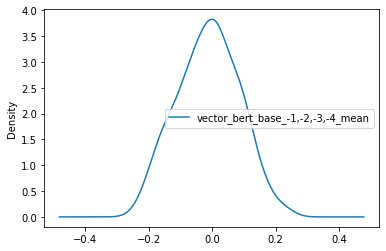

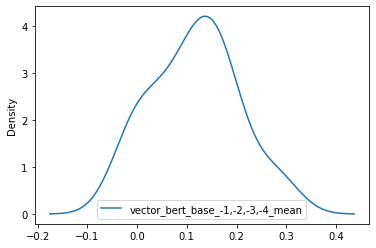

In [32]:
dfL = pd.DataFrame([sims,df_val.label]).T
dfL[dfL.label=="0"].plot(kind='density')
dfL[dfL.label=="1"].plot(kind='density')

In [33]:
df_test[f"bert_contrast_{vector_col}"] = df_test[vector_type].progress_apply(wsd.bert_semaxis_vector,
                                                    sem_axis=sem_axis,
                                                    threshold=.0)
wsd.eval(f"bert_contrast_{vector_col}",df_test)

{'1': [0.112, 0.778, 0.195], '0': [0.969, 0.531, 0.686]}

# Centroid Time Sensitive Methods

In [34]:
ranking = df_test.progress_apply(wsd.bert_ts_binary_centroid_vector, 
                                df_train=df_train, 
                                return_ranking=True, 
                                ts_method='nearest',
                                axis=1)
ranking


387     {'0': 0.36821433901786804, '1': 0.389965444803...
1491    {'0': 0.39285892248153687, '1': 0.442240118980...
1841    {'0': 0.27359530329704285, '1': 0.449292421340...
1244    {'0': 0.3557944595813751, '1': 0.4844100177288...
1809    {'0': 0.3022982180118561, '1': 0.3729205727577...
                              ...                        
736     {'0': 0.4580092430114746, '1': 0.4007811546325...
610     {'0': 0.3777342140674591, '1': 0.3836004137992...
1612    {'0': 0.3818816840648651, '1': 0.2854462563991...
1128    {'0': 0.44910550117492676, '1': 0.440423786640...
1281    {'0': 0.38017234206199646, '1': 0.417573451995...
Length: 383, dtype: object

In [19]:
vector_type = vector_cols[0]
df_test[f"bert_ts_nn_polar_{vector_type}"] = df_test.progress_apply(wsd.bert_ts_binary_centroid_vector, 
                                                        df_train=df_train, 
                                                        ts_method='nearest',
                                                        axis=1)
#wsd.eval(f"bert_ts_nn_polar_{vector_type}",df_test)

In [39]:
#df_test[f"bert_ts_nn_polar_{vector_type}"] = df_test.progress_apply(wsd.bert_ts_semaxis_vector, df_train=df_train, axis=1)
#wsd.eval(f"bert_ts_nn_polar_{vector_type}",df_test)

{'1': [0.0, 0.0, 0.0], '0': [0.904, 1.0, 0.949]}

## At the sense level

In [36]:
senseid2label = dict(df_test[['sense_id','label']].values)
ranking = df_test.progress_apply(wsd.bert_ts_sense_centroid_vector,  
                        senseid2label= senseid2label,
                        ts_method='weighted',
                        return_ranking=True,
                        df_train = df_train, axis=1)
ranking 

387     {'man_nn01-110473987': 0.5567484498023987, 'ma...
1491    {'earth_nn01-135028930': 0.7645291686058044, '...
1841    {'earth_nn01-135028930': 0.6940931677818298, '...
1244    {'person_nn01-30948903': 0.6337188482284546, '...
1809    {'earth_nn01-135028930': 0.6839883923530579, '...
                              ...                        
736     {'machine_nn01-38473945': 0.7028940916061401, ...
610     {'machine_nn01-38473945': 0.6007967591285706, ...
1612    {'body_nn01-134961378': 0.6711238026618958, 'b...
1128    {'personality_nn01-30960078': 0.68657982349395...
1281    {'person_nn01-30948903': 0.5981149673461914, '...
Length: 383, dtype: object

In [37]:
senseid2label = dict(df_test[['sense_id','label']].values)
df_test[f"bert_centroid_sense_{vector_type}"] = df_test.progress_apply(wsd.bert_ts_sense_centroid_vector,  
                        senseid2label= senseid2label,
                        ts_method='nearest',
                        df_train = df_train, axis=1)

wsd.eval(f"bert_centroid_sense_{vector_type}",df_test)


{'1': [0.643, 0.333, 0.439], '0': [0.951, 0.986, 0.968]}

# End.